In [146]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

nltk.downloader.download('vader_lexicon')
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rd/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [147]:
ferrari_df = pd.read_csv('../../data/00-raw-data/ferrari_f1_tweets.csv')
mercedes_df = pd.read_csv('../../data/00-raw-data/mercedes_f1_tweets.csv')
redbull_df = pd.read_csv('../../data/00-raw-data/redbull_f1_tweets.csv')
alfa_romeo_df = pd.read_csv('../../data/00-raw-data/alfa romeo_f1_tweets.csv')
alpha_tauri_df = pd.read_csv('../../data/00-raw-data/alpha tauri_f1_tweets.csv')
alpine_df = pd.read_csv('../../data/00-raw-data/alpine_f1_tweets.csv')
aston_martin_df = pd.read_csv('../../data/00-raw-data/aston martin_f1_tweets.csv')
haas_df = pd.read_csv('../../data/00-raw-data/haas_f1_tweets.csv')
mclaren_df = pd.read_csv('../../data/00-raw-data/mclaren_f1_tweets.csv')
williams_df = pd.read_csv('../../data/00-raw-data/williams_f1_tweets.csv')

In [148]:
def percentage(part,whole):
    
    return 100 * float(part)/float(whole)

In [149]:
def remove_punct(text):
    
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text) #removes numbers from text
    return text

In [150]:
def tokenization(text):
    
    text = re.split('\W+', text)
    return text

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    
    text = [word for word in text if word not in stopword]
    return text

ps = nltk.PorterStemmer()
def stemming(text):
    
    text = [ps.stem(word) for word in text]
    return text

def clean_text(text):
    
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    
    return text

In [152]:
def pipeline(df):
    
    positive = 0
    negative = 0
    neutral = 0
    polarity = 0
    tweet_list = []
    neutral_list = []
    negative_list = []
    positive_list = []

    for tweet in df['text']:
        
        tweet_list.append(tweet)
        analysis = TextBlob(tweet)
        score = SentimentIntensityAnalyzer().polarity_scores(tweet)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        polarity += analysis.sentiment.polarity
        
        if neg > pos:
            
            negative_list.append(tweet)
            negative += 1
            
        elif pos > neg:
            
            positive_list.append(tweet)
            positive += 1
            
        elif pos == neg:
            
            neutral_list.append(tweet)
            neutral = neutral + 1
            
    
    tweet_list = pd.DataFrame(tweet_list)
    neutral_list = pd.DataFrame(neutral_list)
    negative_list = pd.DataFrame(negative_list)
    positive_list = pd.DataFrame(positive_list)

    positive_percentage = percentage(positive,len(tweet_list))
    negative_percentage = percentage(negative,len(tweet_list))
    neutral_percentage = percentage(neutral,len(tweet_list))
    
    tweet_list.drop_duplicates(inplace = True)
    
    tw_list = pd.DataFrame(tweet_list)
    tw_list['text'] = tw_list[0]
    #Removing RT, Punctuation etc
    remove_rt = lambda x: re.sub('@\w+: ', "", x)
    tw_list["text"] = tw_list.text.map(remove_rt)
    tw_list["text"] = tw_list.text.map(remove_punct)
    tw_list["text"] = tw_list.text.str.lower()
    
    tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

    for index, row in tw_list['text'].iteritems():
        score = SentimentIntensityAnalyzer().polarity_scores(row)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if neg > pos:
            tw_list.loc[index, 'sentiment'] = "negative"
        elif pos > neg:
            tw_list.loc[index, "sentiment"] = "positive"
        else:
            tw_list.loc[index, "sentiment"] = "neutral"
    
    tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
    tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
    tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]
            
    tw_list['tokenized'] = tw_list['text'].apply(lambda x: tokenization(x.lower()))
    tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
    tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
    
    countVectorizer = CountVectorizer(analyzer=clean_text) 
    countVector = countVectorizer.fit_transform(tw_list['text'])
    
    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names_out())
    
    count = pd.DataFrame(count_vect_df.sum())
    top_20_count = count.sort_values(0,ascending=False).head(20)
    top_20_count.columns = ['count']
    
    return tw_list, top_20_count

In [153]:
ferrari_sentiment_df, ferrari_top_20_count = pipeline(ferrari_df)
mercedes_sentiment_df, mercedes_top_20_count = pipeline(mercedes_df)
redbull_sentiment_df, redbull_top_20_count = pipeline(redbull_df)
haas_sentiment_df, haas_top_20_count = pipeline(haas_df)
mclaren_sentiment_df, mclaren_top_20_count = pipeline(mclaren_df)
alpine_sentiment_df, alpine_top_20_count = pipeline(alpine_df)
williams_sentiment_df, williams_top_20_count = pipeline(williams_df)
astonmartin_sentiment_df, astonmartin_top_20_count = pipeline(aston_martin_df)
alphatauri_sentiment_df, alphatauri_top_20_count = pipeline(alpha_tauri_df)
alfa_romeo_sentiment_df, alfa_romeo_top_20_count = pipeline(alfa_romeo_df)

In [170]:
ferrari_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/ferrari_sentiment_df.csv')
mercedes_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/mercedes_sentiment_df.csv')
redbull_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/redbull_sentiment_df.csv')
haas_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/haas_sentiment_df.csv')
mclaren_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/mclaren_sentiment_df.csv')
alpine_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/alpine_sentiment_df.csv')
williams_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/williams_sentiment_df.csv')
astonmartin_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/astonmartin_sentiment_df.csv')
alphatauri_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/alphatauri_sentiment_df.csv')
alfa_romeo_sentiment_df.to_csv('../../data/01-modified-data/sentiment_analysis/alfa_romeo_sentiment_df.csv')

In [166]:
all_teams_top20_count = pd.concat([ferrari_top_20_count, mercedes_top_20_count, redbull_top_20_count, haas_top_20_count, mclaren_top_20_count, alpine_top_20_count, williams_top_20_count, astonmartin_top_20_count, alphatauri_top_20_count, alfa_romeo_top_20_count], axis=1)
all_teams_top20_count.reset_index(inplace=True)
all_teams_top20_count.columns = ['words', 'ferrari', 'mercedes', 'redbull', 'haas', 'mclaren', 'alpine', 'williams', 'aston martin', 'alpha tauri', 'alfa romeo']
all_teams_top20_count.to_csv('../../data/01-modified-data/all_teams_top20_wordcount.csv')

In [181]:
all_teams_top20_count

,words,ferrari,mercedes,redbull,haas,mclaren,alpine,williams,aston martin,alpha tauri,alfa romeo
0,ferrari,481.0,53.0,37.0,NaN,44.0,NaN,NaN,NaN,NaN,NaN
1,f,399.0,551.0,328.0,423.0,631.0,483.0,551.0,313.0,102.0,191.0
2,race,93.0,106.0,57.0,52.0,85.0,58.0,96.0,34.0,NaN,NaN
3,,68.0,61.0,31.0,45.0,78.0,59.0,53.0,30.0,NaN,NaN
4,team,50.0,122.0,40.0,76.0,65.0,59.0,90.0,83.0,24.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
85,hurri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
86,ceo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
87,say,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
88,sauber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0


In [178]:
keys = ['Ferrari', 'Mercedes', 'Redbull', 'Haas', 'Mclaren', 'Alpine', 'Williams', 'Aston Martin', 'Alpha Tauri', 'Alfa Romeo']
all_teams_sentiment_df = pd.concat([ferrari_sentiment_df, mercedes_sentiment_df, redbull_sentiment_df, haas_sentiment_df, mclaren_sentiment_df, alpine_sentiment_df, williams_sentiment_df, astonmartin_sentiment_df, alphatauri_sentiment_df, alfa_romeo_sentiment_df], keys=keys, names=['Team', None], axis=0).reset_index(level = 'Team')

In [180]:
all_teams_sentiment_df.to_csv('../../data/01-modified-data/all_teams_sentiment_df.csv')

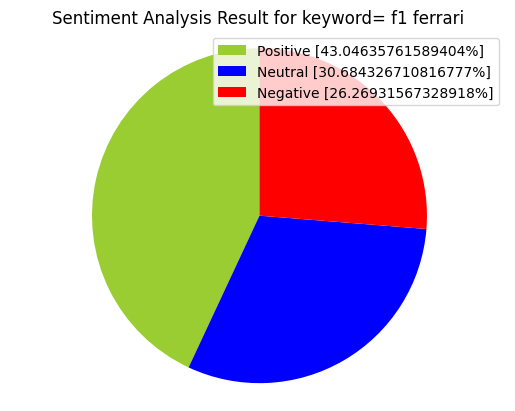

In [98]:
labels = ["Positive ["+str(positive_percentage)+"%]" , "Neutral ["+str(neutral_percentage)+"%]","Negative ["+str(negative_percentage)+"%]"]
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+keyword+"")
plt.axis('equal')
plt.show()

In [155]:
def create_wordcloud(text):
    #mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                    max_words=3000,
                    stopwords=stopwords,
                    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


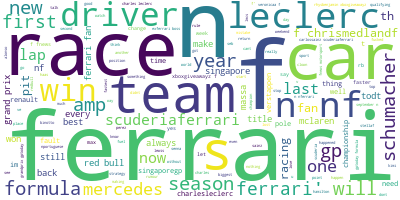

In [132]:
create_wordcloud(tw_list["text"].values)

Word Cloud Saved Successfully


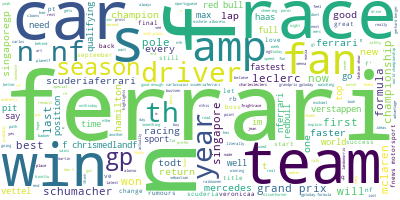

In [133]:
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


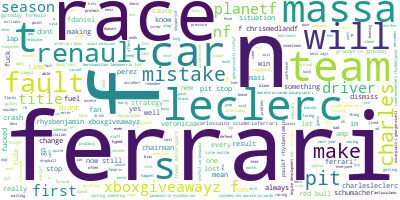

In [134]:
create_wordcloud(tw_list_negative["text"].values)

In [135]:
tw_list["text_len"] = tw_list["text"].astype(str).apply(len)
tw_list["text_word_count"] = tw_list["text"].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,144.18
neutral,88.48
positive,148.18


In [136]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,23.98
neutral,13.43
positive,24.01
